# Load packages and data stuff

In [1]:
%load_ext tensorboard
from helpers_image_pricecat import *
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import itertools
import io
import shap
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Init Plugin
Init Graph Optimizer
Init Kernel


Load the listings and extract the price

In [2]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
urls = listings["listing_url"]
ids = listings["id"]
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [3]:
# MAKE PRICE CATEGORIES

# form size dependent groups
listings["size_group"] = listings["accommodates"].astype(str)

# consider all listings that are for more than 6 people as one group
filter = listings["accommodates"] > 8
listings["size_group"][filter] = "greater 8"

# construct new column that is basically the price of the listing. Only correct the price for the group >6 by dividing by accommodates
listings["price_adj"] = price["log_price"]
listings["price_adj"][filter] = (price["price"]/listings["accommodates"])[filter]

# find the group specific quantiles
quantiles = listings.groupby(listings["size_group"]).quantile([0,0.05,0.25,0.75,0.95,1])["price_adj"]

# construct new column that gives the price category in the groups by taking the group quantiles into account
listings["price_category"] = np.repeat(None, len(listings))
for size_gr in np.unique(listings["size_group"]):
    filter = listings["size_group"] == size_gr
    q = quantiles[size_gr]
    # adjust lower and upper bound
    q[0] = q[0]-1
    q[1] = q[1]+1
    listings["price_category"][filter] = pd.cut(listings["price_adj"][filter], bins = q, labels = ["very cheap", "cheap", "middle", "expensive", "very expensive"])



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [4]:
listings["accommodates"].value_counts()

2     3213
4     1211
1     1066
6      453
3      383
5      296
7      132
8      129
10      28
12      18
9       17
11      11
16       7
14       5
15       4
13       3
Name: accommodates, dtype: int64

In [5]:
listings["price_category"].value_counts()

middle            3395
cheap             1482
expensive         1331
very cheap         417
very expensive     351
Name: price_category, dtype: int64

Set the path to the downloaded and resized images

In [6]:
folder_images = "data/images_resized"
img_path = os.listdir(folder_images)

Set up a dataframe which contains the listing id the number of the image for the id and its corresponding path alongside with the price category

In [7]:
images_path = pd.Series(img_path)
listing_ids = np.squeeze(images_path.str.extract("(^\d*_\d*)").values)

In [8]:
images_df = pd.Series(listing_ids).str.split("_", expand = True)
images_df.columns = ["id", "img_no"]
images_df["img_path"] = [str(l) + ".png" for l in list(listing_ids)]

# .DS -File is also in folder. Drop that row
images_df = images_df.dropna()
images_df

,id,img_no,img_path
0,19917816,12,19917816_12.png
1,15814444,6,15814444_6.png
2,23958167,21,23958167_21.png
3,9851118,0,9851118_0.png
4,51243476,13,51243476_13.png
...,...,...,...
86441,22159651,6,22159651_6.png
86442,30737269,10,30737269_10.png
86443,24031304,6,24031304_6.png
86444,6580137,6,6580137_6.png


In [9]:
# join prices and df with ids, img_no and paths
listings["id"] = listings["id"].astype(int)
images_df["id"] = images_df["id"].astype(int)
img_list_df = images_df.merge(listings[["id", "price_category"]], how = "left", on = "id")
img_list_df["id"] = img_list_df["id"].astype(str)

unique_ids = np.unique(img_list_df["id"])

# Model for collage of 5 images

In [10]:
# only first 5 pictures of each id
df_collage = img_list_df[img_list_df["img_no"].astype(int)<=4]

# dataframe with id and its price category
id_price_df = df_collage[["id", "price_category"]]
id_price_df = id_price_df.drop_duplicates()

# unique id with its price category
unique_ids = id_price_df["id"].astype(str)
unique_price = id_price_df["price_category"]
img_stacked = []

Save collage images

In [11]:
df_collage

,id,img_no,img_path,price_category
3,9851118,0,9851118_0.png,middle
8,13071668,2,13071668_2.png,very cheap
10,30948708,0,30948708_0.png,middle
16,51031542,1,51031542_1.png,middle
20,20358903,0,20358903_0.png,middle
...,...,...,...,...
86425,12811219,1,12811219_1.png,middle
86426,45430042,4,45430042_4.png,expensive
86433,17787937,3,17787937_3.png,middle
86436,36601270,3,36601270_3.png,middle


In [33]:
images = []
ids = []
price = []

for id in tqdm(unique_ids):
    filter = df_collage["id"] == id
    paths = df_collage["img_path"][filter]
    img_tmp = []
    counter = 0
    for p in np.tile(paths, 5):
        img_tmp.append(cv2.imread("data/images_resized/"+p))
        counter += 1
        if counter == 5:
            break
    ids.append(id)
    price.append(np.unique(df_collage["price_category"][filter].values))
    img_tmp = np.hstack(img_tmp)
    #cv2.imwrite("data/image_collage/"+id+".png", img_tmp)
    images.append(img_tmp)
images = np.stack(images)
ids = np.stack(ids)
price = npnp.stack(price)

100%|██████████| 6315/6315 [03:11<00:00, 32.96it/s]


In [34]:
np.save("data/images_collage.npy", images)
np.save("data/ids_collage.npy", ids)
np.save("data/price_collage.npy", price)

In [14]:
images = np.load("data/images_collage.npy", allow_pickle = True)
ids = np.load("data/ids_collage.npy")
price = np.load("data/price_collage.npy", allow_pickle = True)

In [15]:
price = np.squeeze(price)

In [45]:
from sklearn import preprocessing
# store label in one column
le = preprocessing.LabelEncoder()
le.fit(price)
price = le.transform(price)
label_book = id_price_df[["price_category","price_category_label"]].drop_duplicates().sort_values(by="price_category_label")
label_book

KeyError: "['price_category_label'] not in index"

In [35]:
label_book = pd.DataFrame({"label": np.arange(5), "label_cat": le.inverse_transform(np.arange(5))})

In [36]:
label_book

,label,label_cat
0,0,cheap
1,1,expensive
2,2,middle
3,3,very cheap
4,4,very expensive


In [19]:
X_train, X_test, y_train, y_test = train_test_split(images, price, random_state = 123, test_size = 0.2)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2

In [20]:
batch_size = 4

In [21]:
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_train = data_train.cache()
data_train = data_train.shuffle(6000, seed = 13)
train_dataset = data_train.take(len(y_train))
train_dataset = train_dataset.batch(batch_size)

data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
data_test = data_test.cache()
test_dataset = data_test.take(len(y_test))
test_dataset = test_dataset.batch(batch_size)

data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
data_val = data_val.cache()
val_dataset = data_val.take(len(y_val))
val_dataset = val_dataset.batch(batch_size)

2022-02-02 19:13:58.514944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 19:13:58.516618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [22]:
y_train

array([2, 0, 0, ..., 3, 2, 4])

In [23]:
weights = 1/(pd.Series(y_train).value_counts()/len(y_train))
weights = weights.to_dict()
weights

{2: 2.0286144578313254,
 0: 4.7992874109263655,
 1: 5.352317880794701,
 3: 17.195744680851064,
 4: 18.622119815668203}

In [24]:
class Images_pricecat(tf.keras.Model):

  def __init__(self, l2, dropout):
    super().__init__()
    self.resnet_pre = keras.applications.resnet50.preprocess_input
    self.resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', pooling="avg", input_shape = (None,None,3))
    self.resnet.trainable = False
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.drop1 = tf.keras.layers.Dropout(dropout)
    self.dense1 = tf.keras.layers.Dense(128, activation= "relu", kernel_regularizer = tf.keras.regularizers.l2(l2))
    self.drop2 = tf.keras.layers.Dropout(dropout)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

  def call(self, inputs):
    x = self.resnet_pre(inputs)
    x = self.resnet(x)
  
    x = self.bn1(x)
    x = self.drop1(x)
    x = self.dense1(x)
    x = self.drop2(x)
    return self.dense2(x)
  

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

In [29]:
model = Images_pricecat(l2 = 0, dropout = 0.3)
logdir = "logs/price/lr/0_00001_0202"
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.9, staircase=False)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
model.compile(optimizer=keras.optimizers.Adam(lr),
                    loss= keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics=["accuracy"])
model.fit(train_dataset, validation_data = val_dataset, epochs = 5, class_weight = weights, callbacks = [tensorboard_callback, early_stopping])


2022-02-02 23:01:37.813644: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 23:01:37.813668: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-02 23:01:37.814603: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/5


2022-02-02 23:01:40.019524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   1/1011 [..............................] - ETA: 35:01 - loss: 6.1465 - accuracy: 0.2500

2022-02-02 23:01:41.036622: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 23:01:41.036634: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


   2/1011 [..............................] - ETA: 6:30 - loss: 6.4962 - accuracy: 0.3750 

2022-02-02 23:01:41.436787: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-02 23:01:41.445399: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-02 23:01:41.459260: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/price/lr/0_00001_0202/train/plugins/profile/2022_02_02_23_01_41
2022-02-02 23:01:41.462614: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/price/lr/0_00001_0202/train/plugins/profile/2022_02_02_23_01_41/Air-von-Dominik.fritz.box.trace.json.gz
2022-02-02 23:01:41.469410: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/price/lr/0_00001_0202/train/plugins/profile/2022_02_02_23_01_41
2022-02-02 23:01:41.469600: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/price/lr/0_00001_0202/train/pl

1011/1011 [==============================] - ETA: 0s - loss: 13.2119 - accuracy: 0.2316

2022-02-02 23:07:02.698564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1011/1011 [==============================] - 419s 413ms/step - loss: 13.2119 - accuracy: 0.2316 - val_loss: 1.9583 - val_accuracy: 0.2344
Epoch 2/5
1011/1011 [==============================] - 509s 504ms/step - loss: 8.2184 - accuracy: 0.2722 - val_loss: 1.5967 - val_accuracy: 0.2779
Epoch 3/5
1011/1011 [==============================] - 527s 522ms/step - loss: 7.4928 - accuracy: 0.2781 - val_loss: 1.6906 - val_accuracy: 0.2285
Epoch 4/5
1011/1011 [==============================] - 573s 567ms/step - loss: 7.0119 - accuracy: 0.3093 - val_loss: 1.6762 - val_accuracy: 0.2878
Epoch 5/5
1011/1011 [==============================] - 568s 562ms/step - loss: 6.9906 - accuracy: 0.3039 - val_loss: 1.6890 - val_accuracy: 0.2681


In [31]:
model.save(logdir)

2022-02-01 01:53:29.000744: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


INFO:tensorflow:Assets written to: logs/price/lr/0_00001_3101/assets


In [33]:
model.layers[0].trainable = True
from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.00001)

logdir = "logs/collage_cat/resnet_finalmodel_0202_weights_retrained"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(train_dataset, validation_data = val_dataset , epochs = 50, callbacks = [tensorboard_callback, early_stopping], class_weight = weights)

2022-02-02 23:48:26.496148: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 23:48:26.496278: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-02 23:48:26.499000: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/50
   1/1011 [..............................] - ETA: 10:03 - loss: 4.8466 - accuracy: 0.5000

2022-02-02 23:48:28.439637: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 23:48:28.439653: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


   2/1011 [..............................] - ETA: 9:11 - loss: 3.9636 - accuracy: 0.5000 

2022-02-02 23:48:28.858090: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-02-02 23:48:28.865184: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-02 23:48:28.880895: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/collage_cat/resnet_finalmodel_0202_weights_retrained/train/plugins/profile/2022_02_02_23_48_28
2022-02-02 23:48:28.884762: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/collage_cat/resnet_finalmodel_0202_weights_retrained/train/plugins/profile/2022_02_02_23_48_28/Air-von-Dominik.fritz.box.trace.json.gz
2022-02-02 23:48:28.908038: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/collage_cat/resnet_finalmodel_0202_weights_retrained/train/plugins/profile/2022_02_02_23_48_28
2022-02-02 23:48:28.908254: I tensorflow/core/profiler/rpc/client/save_profile.cc:14

1011/1011 [==============================] - 419s 415ms/step - loss: 6.5681 - accuracy: 0.3445 - val_loss: 1.5457 - val_accuracy: 0.3551
Epoch 2/50
1011/1011 [==============================] - 528s 522ms/step - loss: 6.2007 - accuracy: 0.3440 - val_loss: 1.8392 - val_accuracy: 0.2334
Epoch 3/50
1011/1011 [==============================] - 555s 549ms/step - loss: 6.1773 - accuracy: 0.3516 - val_loss: 1.7883 - val_accuracy: 0.2789
Epoch 4/50
1011/1011 [==============================] - 611s 605ms/step - loss: 5.9329 - accuracy: 0.3719 - val_loss: 1.7722 - val_accuracy: 0.2799
Epoch 5/50
1011/1011 [==============================] - 598s 591ms/step - loss: 5.7333 - accuracy: 0.3989 - val_loss: 1.8930 - val_accuracy: 0.2641
Epoch 6/50
1011/1011 [==============================] - 595s 589ms/step - loss: 5.3582 - accuracy: 0.4147 - val_loss: 1.9640 - val_accuracy: 0.2562
Epoch 7/50
1011/1011 [==============================] - 599s 592ms/step - loss: 5.0181 - accuracy: 0.4422 - val_loss: 1.912

Create train, test, val data from collages

### Visualization

In [38]:

# path_final_model = 'logs/collage_cat/resnet_finalmodel_21_01_weights'
# model = tf.keras.models.load_model(path_final_model)

X = np.concatenate([x[0] for x, y in test_dataset], axis=0)
X = X.astype(float)

In [41]:
X.shape

(80896, 1280, 3)

In [44]:
class_names = list(np.ravel(label_book.set_index("price_category_label").values))

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)
# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[0:1], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

KeyError: "None of ['price_category_label'] are in the columns"

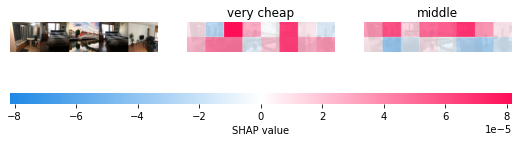

In [47]:
# output with shap values
shap.image_plot(shap_values, width = 1000, hspace = 3)

We have to define some functions first (see Keras documentation GradCam)

In [61]:
model_resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_1 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2048)              8192

In [66]:
# get test cases
for i in val_dataset.take(1):
  img_arrays = i[0]["input_1"]
  prices = i[1]

model_builder = model_resnet
preprocess_input = keras.applications.resnet.preprocess_input
last_conv_layer_name = "conv5_block3_3_conv"
b, w, h, d = img_arrays.shape

Predicted:  [  0.6659273 166.69473     0.7357683   1.1744347   0.3469204]
True:  2.718281828459045


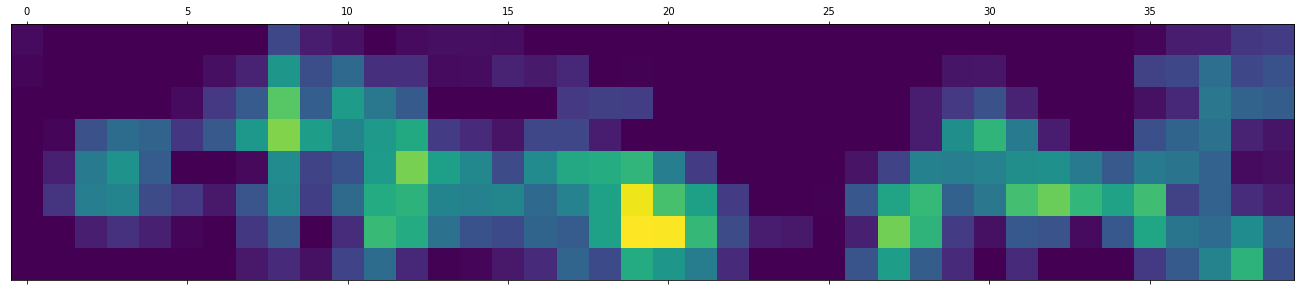

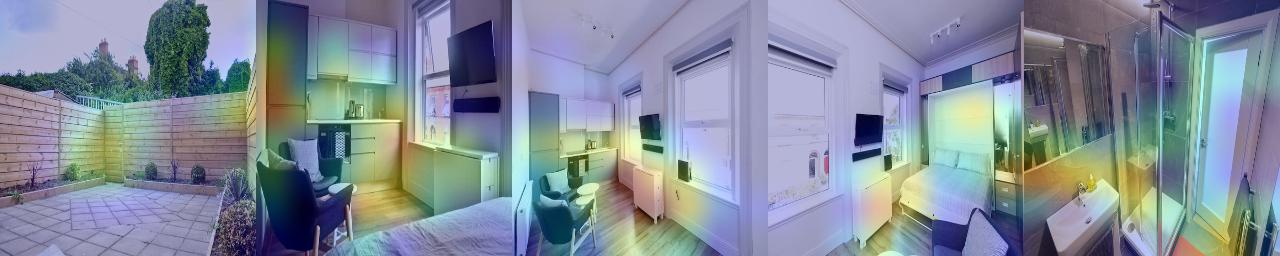

Predicted:  [0.8566114  0.38003188 1.1039668  2.698866   0.07265554]
True:  7.38905609893065


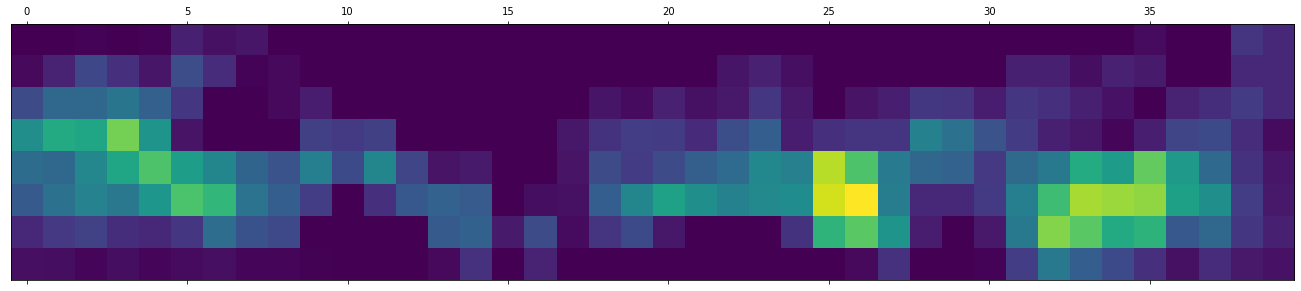

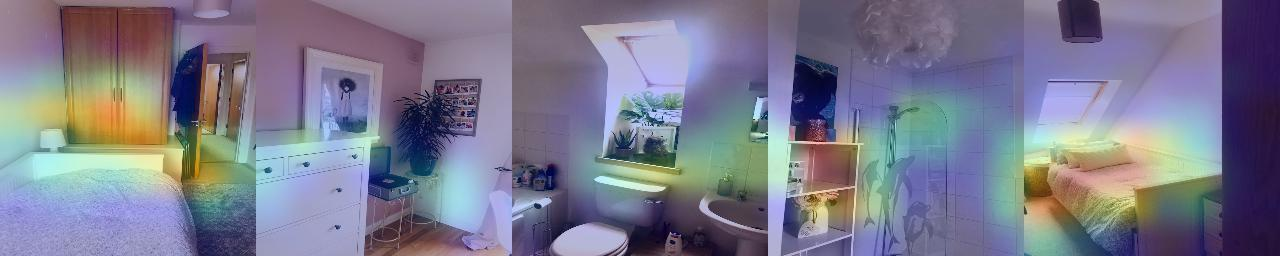

Predicted:  [ 0.08138072 40.4961      1.9608773   2.5722547   0.04309629]
True:  7.38905609893065


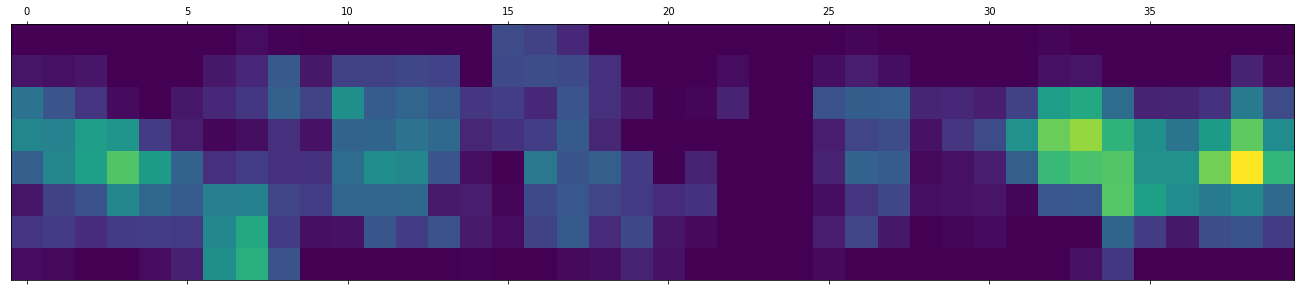

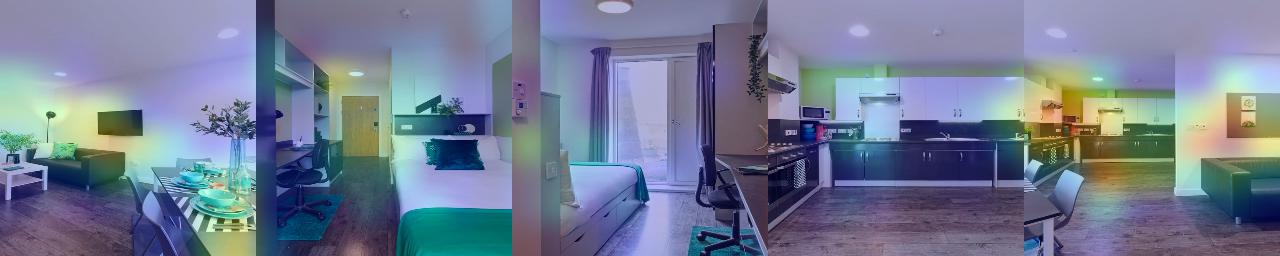

Predicted:  [9.4379368e+00 4.7696537e-01 7.2628365e+01 4.4783139e-01 4.5191843e-02]
True:  2.718281828459045


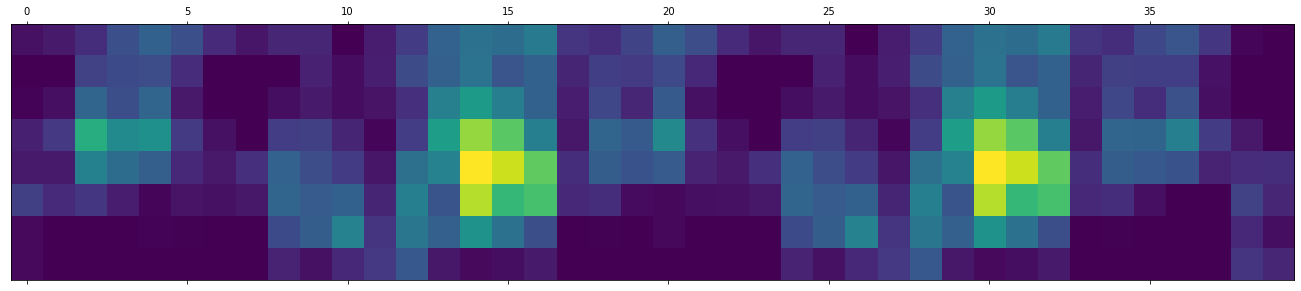

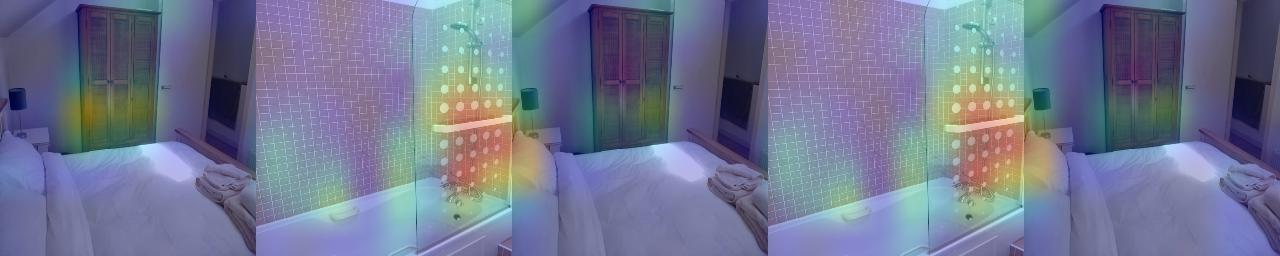

Predicted:  [2.0918470e+01 2.6203809e-02 2.7026005e+00 9.7439224e+01 6.9987988e-01]
True:  1.0


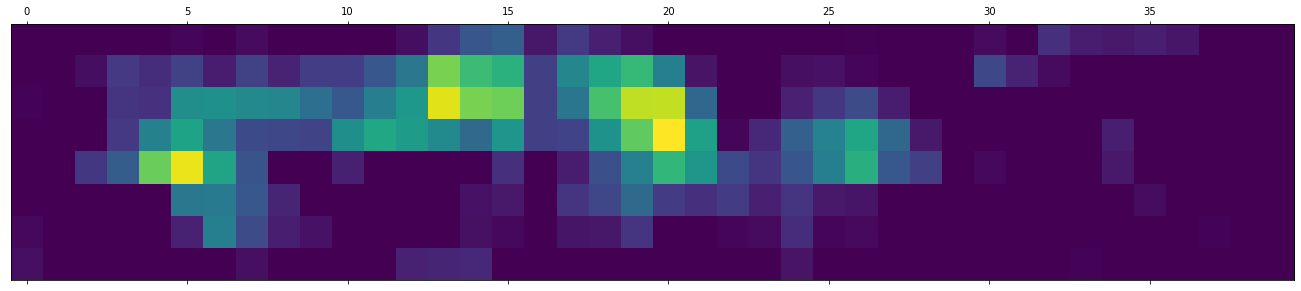

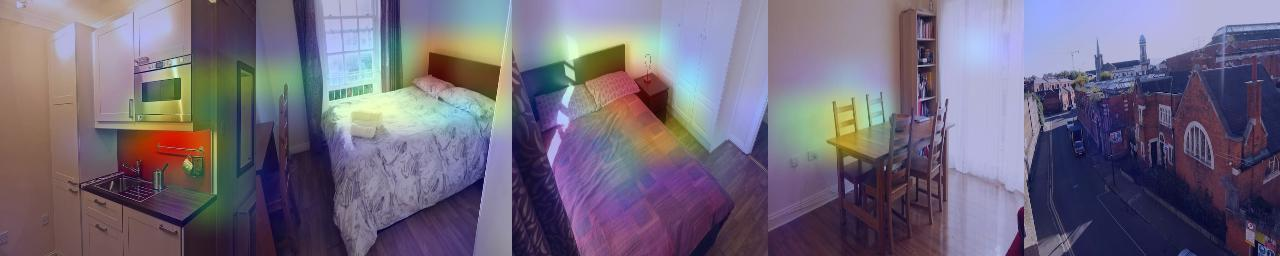

Predicted:  [11.789536    0.03971542  3.523835   17.328985    0.18612221]
True:  1.0


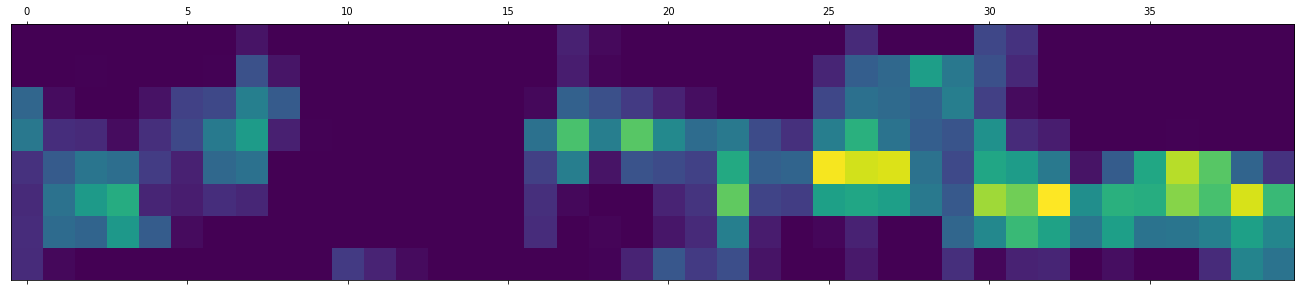

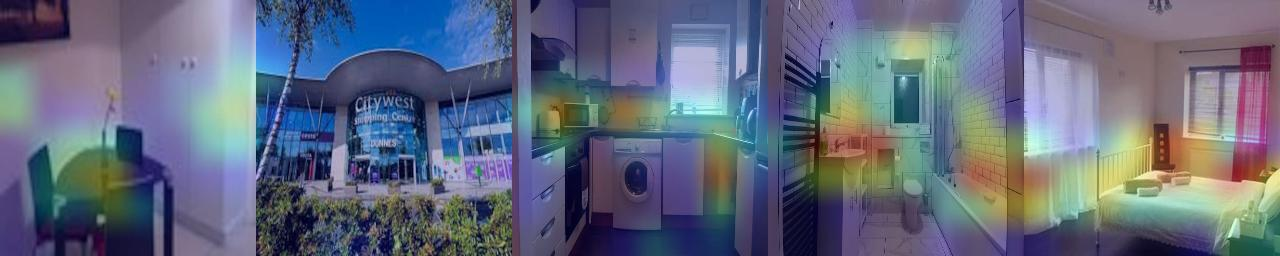

Predicted:  [4.1812460e+02 1.8547069e-01 5.2842517e+00 1.6755271e+00 2.7679021e-03]
True:  1.0


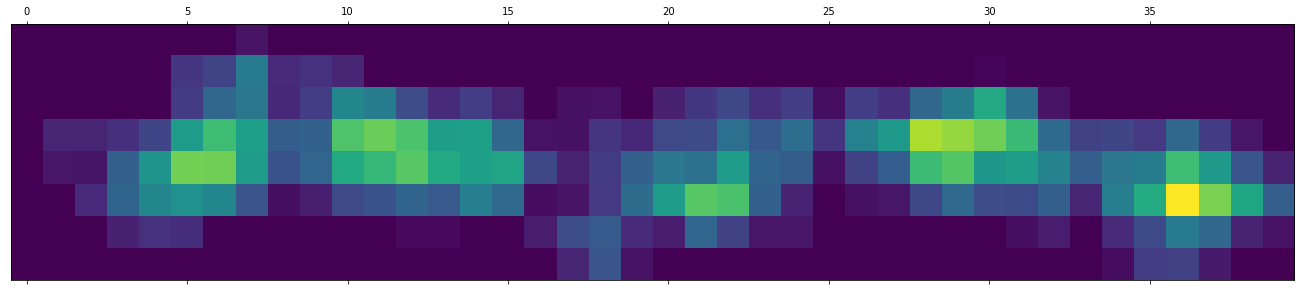

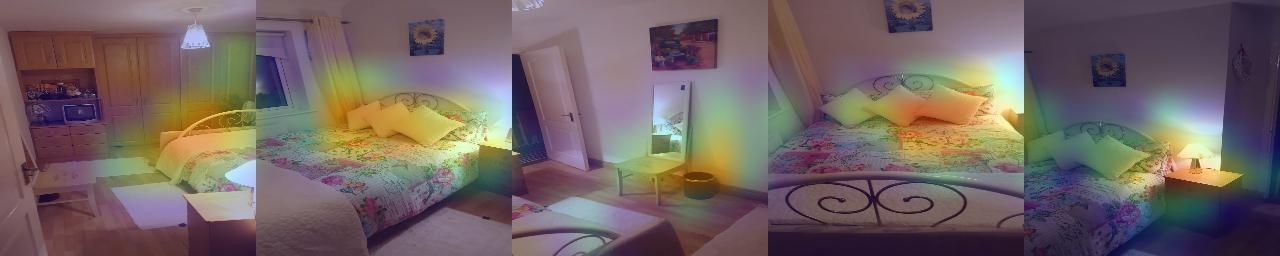

Predicted:  [ 1.3950156   0.7748532  10.688229    0.5239878   0.38583532]
True:  2.718281828459045


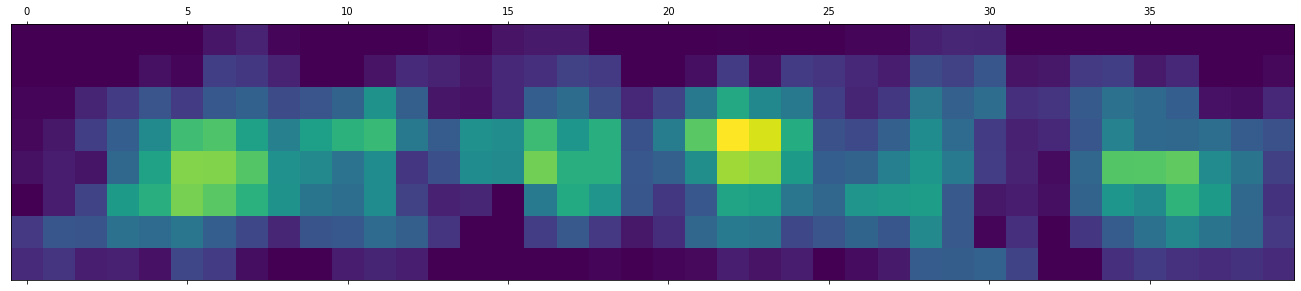

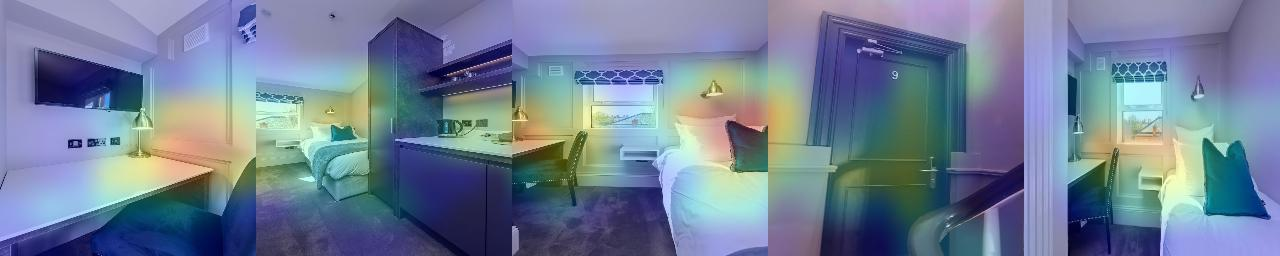

Predicted:  [0.8050946 5.671884  5.4718885 0.2013348 0.6471721]
True:  7.38905609893065


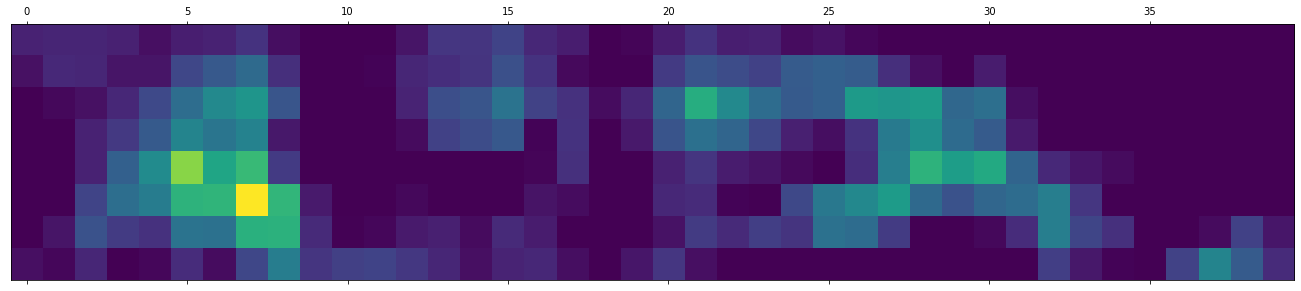

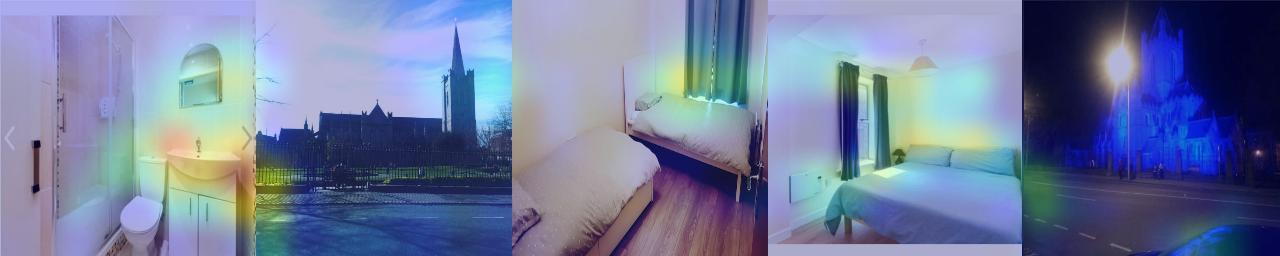

Predicted:  [ 0.9988207   0.3888458   2.274211   18.657297    0.16024451]
True:  7.38905609893065


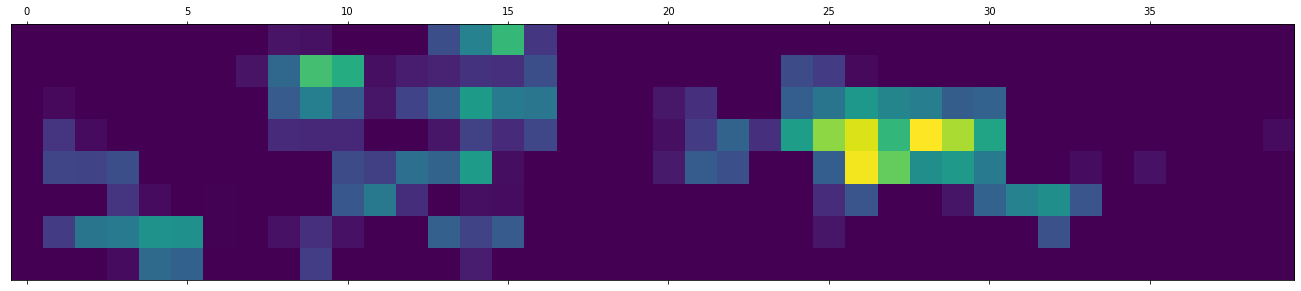

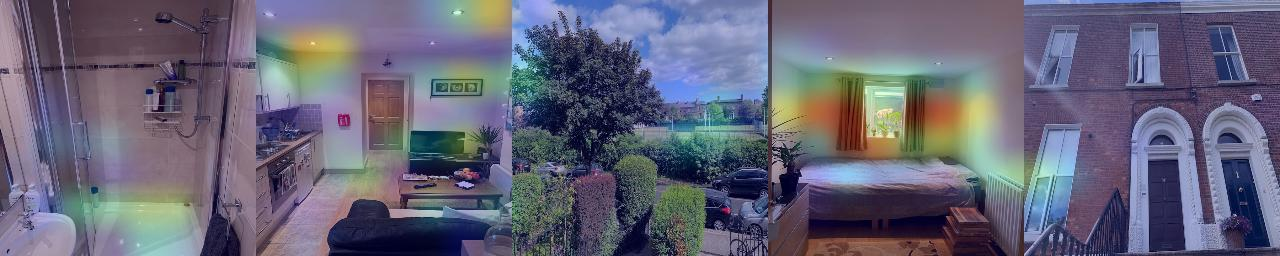

In [67]:
for i in range(b):
  img_array = img_arrays[i]
  img_size = (w,h)
  img_array = preprocess_input(np.expand_dims(img_array, axis=0))

  # Print what the top predicted class is
  preds = model_resnet.predict(img_array)
  print("Predicted: ", np.exp(np.squeeze(preds)))
  print("True: ", np.exp(np.squeeze(prices[i])))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model_resnet, last_conv_layer_name)

  # Display heatmap
  plt.figure(figsize=(23,16))
  plt.matshow(heatmap, fignum = 1)
  ax = plt.gca()
  ax.axes.yaxis.set_visible(False)
  plt.show()

  img_array = img_arrays[i]
  img_array = img_array.numpy().astype(float)

  save_and_display_gradcam(img_array, heatmap)

# Model for single images

Next, write tf-record files which contain the images and prices for each id

In [ ]:
raise Exception("Stop!")
for id in tqdm(unique_ids):
    filter = df_compl["id"] == id
    data_to_write = df_compl[filter]
    # for computational reasons, only take first picture
    data_to_write = data_to_write[data_to_write["img_no"]=="0"]
    filename = folder_tfrecord +"/"+ id
    write_features(data_to_write["id"].values, data_to_write["path"].values, data_to_write["log_price"].values, path = folder_images+"/", filename = filename)


Exception: Stop!

Split data in training, test and validation ids, store corresponding tf-record data and create datasets

In [ ]:
X_train, X_test = train_test_split(unique_ids, test_size=0.2, random_state=1)

X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
X_train = [folder_tfrecord + "/" + f + ".tfr" for f in X_train.astype(str)]
X_test = [folder_tfrecord + "/" + f + ".tfr" for f in X_test.astype(str)]
X_val = [folder_tfrecord + "/" + f + ".tfr" for f in X_val.astype(str)]

In [ ]:
train_dataset = make_dataset(X_train, batch_size = 10)
test_dataset = make_dataset(X_test, batch_size = 10)
val_dataset = make_dataset(X_val, batch_size = 10)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
basemodel = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = tf.keras.layers.Input(shape = (256, 256, 3), name = "input_1")
)
basemodel.trainable = False

outputs = tf.keras.layers.Dense(100, activation = "relu")(basemodel.output)
outputs = tf.keras.layers.Dense(1)(outputs)

model = tf.keras.Model(basemodel.input, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
              loss=tf.keras.losses.MeanSquaredError())
model.fit(train_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-29 13:17:45.983243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-29 13:17:45.983782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


    378/Unknown - 115s 299ms/step - loss: 6.0016

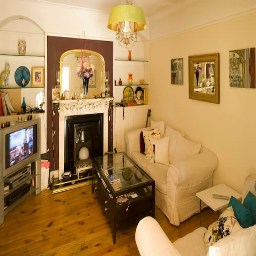

In [ ]:
model_builder = model

preprocess_input = keras.applications.efficientnet.preprocess_input

last_conv_layer_name = "top_conv"

# The local path to our target image"
img_path = "data/images_resized/44077_1.png"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[7.352597]]


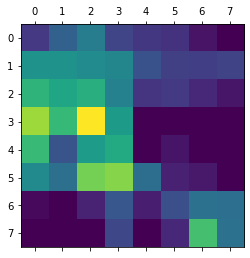

In [ ]:
img_size = (256,256)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

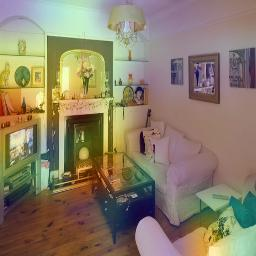

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)